# Structured data classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/06/09<br>
**Last modified:** 2020/06/09<br>
**Description:** Binary classification of structured data including numerical and categorical features.

## Introduction

This example demonstrates how to do structured data classification, starting from a raw
CSV file. Our data includes both numerical and categorical features. We will use Keras
preprocessing layers to normalize the numerical features and vectorize the categorical
ones.

Note that this example should be run with TensorFlow 2.5 or higher.

### The dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Setup

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

## Preparing the data

Let's download the data and load it into a Pandas dataframe:

In [3]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):

In [4]:
dataframe.shape

(303, 14)

Here's a preview of a few samples:

In [5]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

Let's split the data into a training and validation set:

In [6]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


Let's generate `tf.data.Dataset` objects for each dataframe:

In [7]:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

2021-10-08 10:27:40.992055: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:

In [8]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=57>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=120>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=354>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=163>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.6>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


Let's batch the datasets:

In [9]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

## Feature preprocessing with Keras layers


The following features are categorical features encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

We will encode these features using **one-hot encoding**. We have two options
here:

 - Use `CategoryEncoding()`, which requires knowing the range of input values
 and will error on input outside the range.
 - Use `IntegerLookup()` which will build a lookup table for inputs and reserve
 an output index for unkown input values.

For this example, we want a simple solution that will handle out of range inputs
at inference, so we will use `IntegerLookup()`.

We also have a categorical feature encoded as a string: `thal`. We will create an
index of all possible features and encode output using the `StringLookup()` layer.

Finally, the following feature are continuous numerical features:

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

For each of these features, we will use a `Normalization()` layer to make sure the mean
of each feature is 0 and its standard deviation is 1.

Below, we define 3 utility functions to do the operations:

- `encode_numerical_feature` to apply featurewise normalization to numerical features.
- `encode_string_categorical_feature` to first turn string inputs into integer indices,
then one-hot encode these integer indices.
- `encode_integer_categorical_feature` to one-hot encode integer categorical features.

In [10]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


## Build a model

With this done, we can create our end-to-end model:

In [11]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

2021-10-08 10:27:41.143362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Let's visualize our connectivity graph:

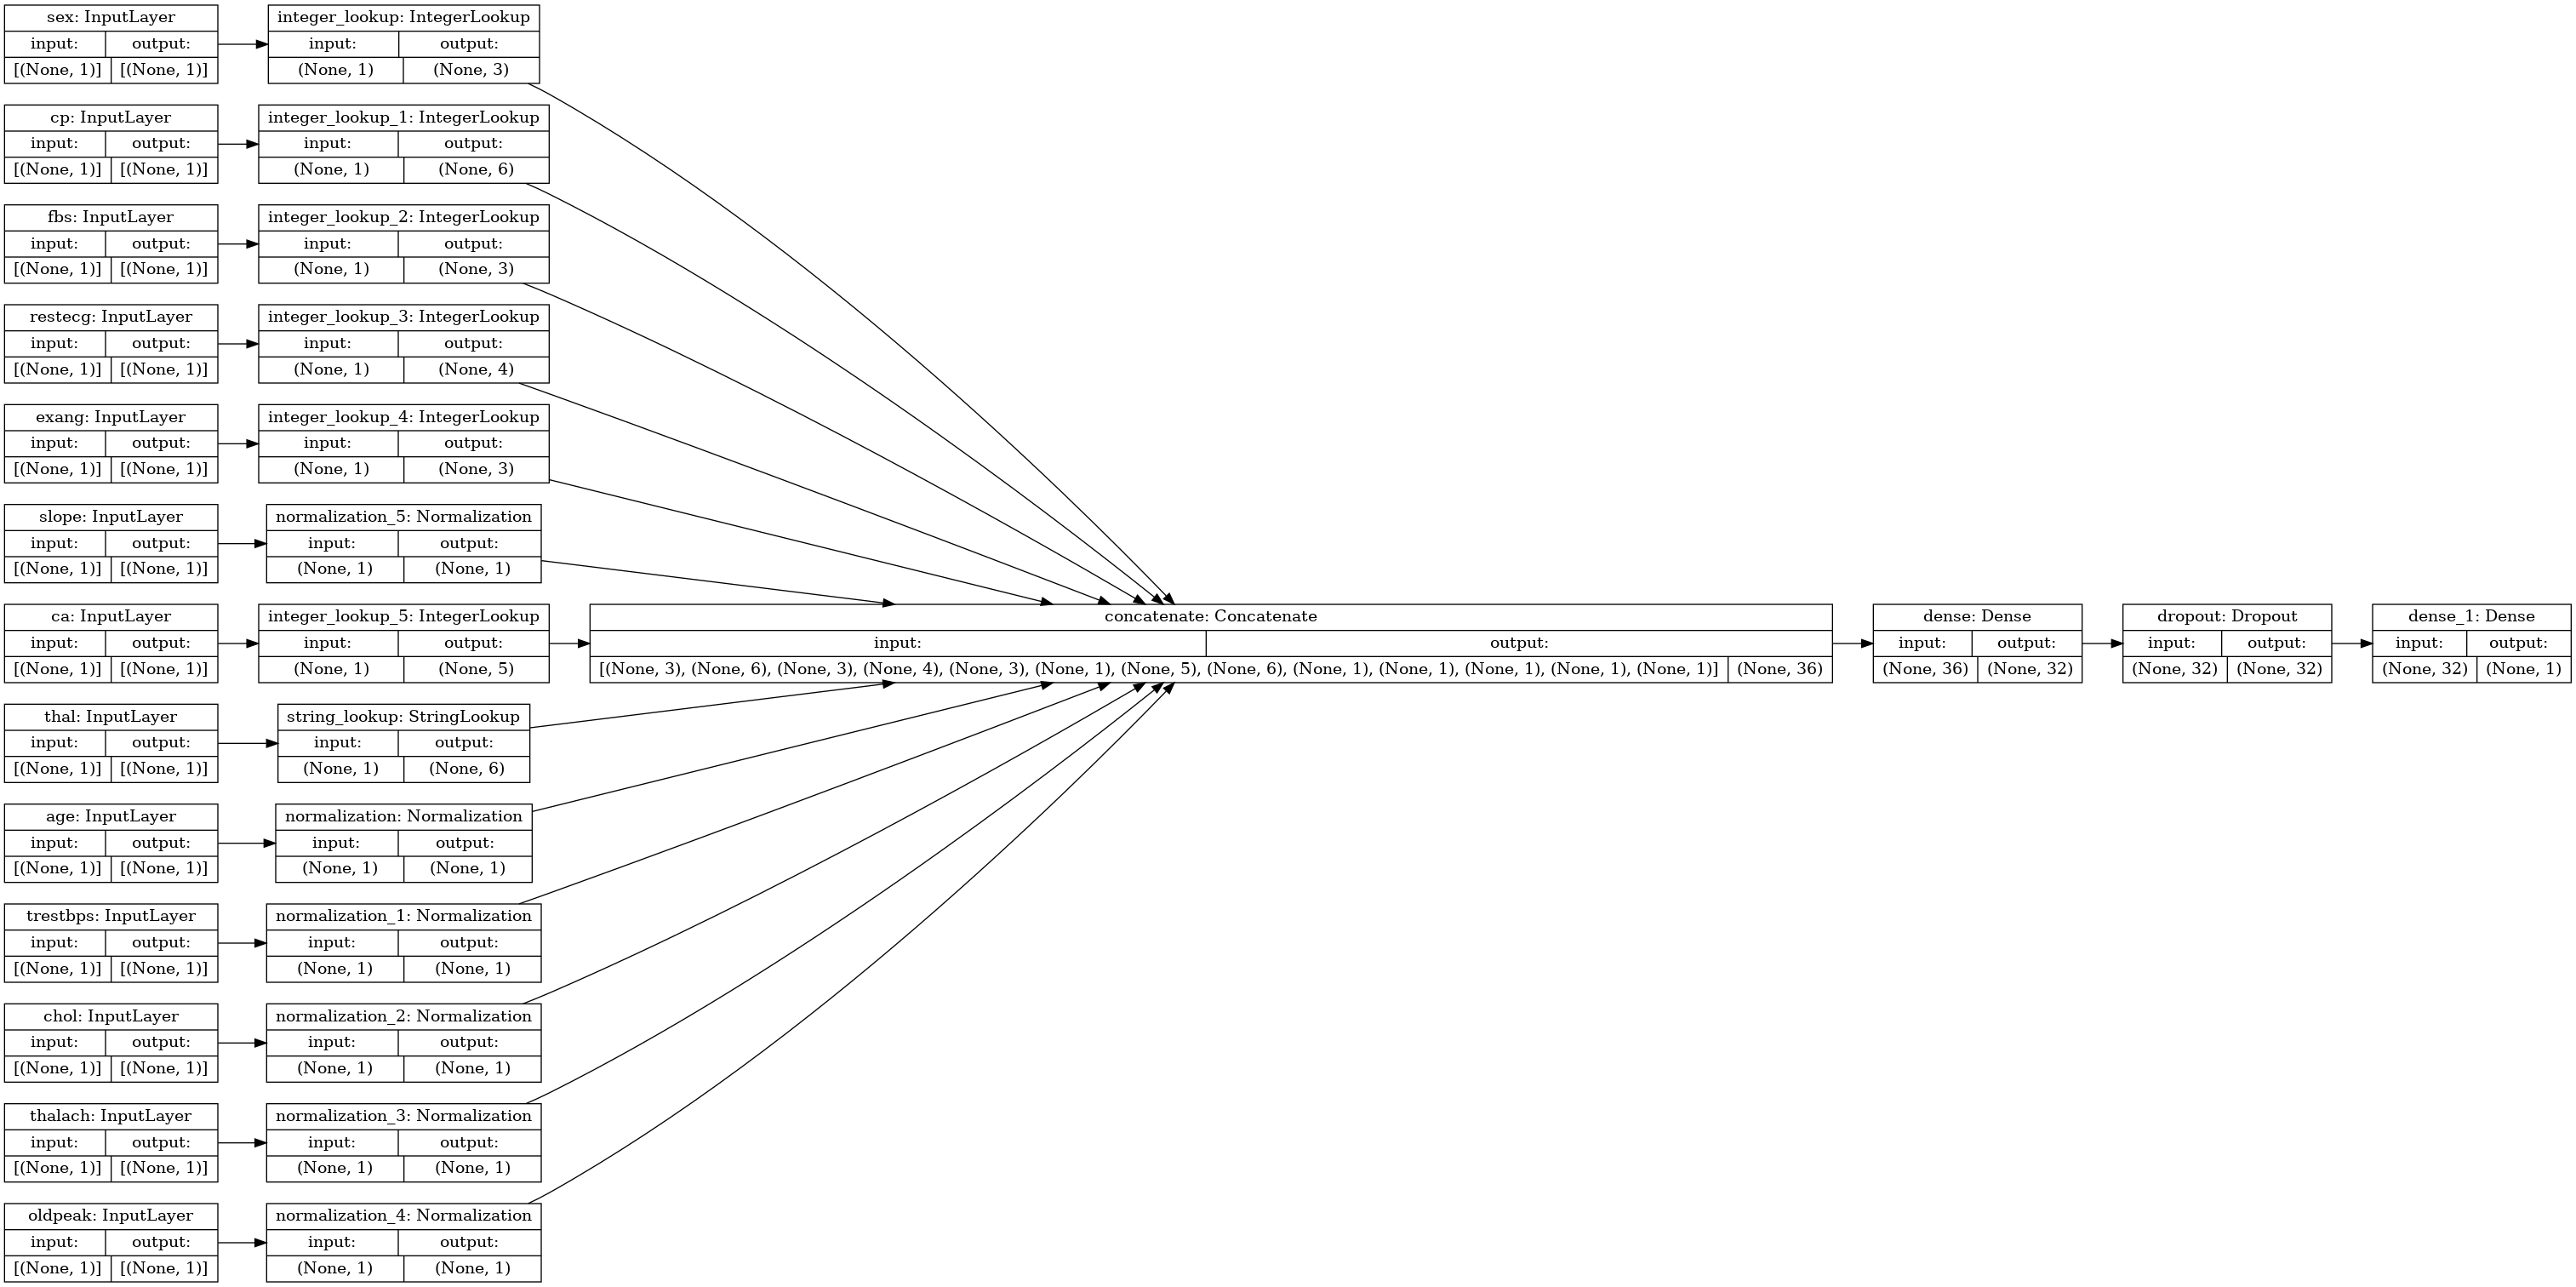

In [12]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train the model

In [13]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 1s 71ms/step - loss: 0.7598 - accuracy: 0.4669 - val_loss: 0.6881 - val_accuracy: 0.5410
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6906 - accuracy: 0.5702 - val_loss: 0.6290 - val_accuracy: 0.7049
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.6751 - accuracy: 0.5661 - val_loss: 0.5820 - val_accuracy: 0.7869
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.6219 - accuracy: 0.6198 - val_loss: 0.5455 - val_accuracy: 0.8033
Epoch 5/50
1/8 [==>...........................] - ETA: 0s - loss: 0.5613 - accuracy: 0.7812

2021-10-08 10:27:45.247566: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-10-08 10:27:45.344727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


8/8 [==============================] - 0s 8ms/step - loss: 0.5596 - accuracy: 0.7355 - val_loss: 0.5180 - val_accuracy: 0.7869
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5482 - accuracy: 0.7190 - val_loss: 0.4943 - val_accuracy: 0.7705
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.5141 - accuracy: 0.7603 - val_loss: 0.4756 - val_accuracy: 0.8033


2021-10-08 10:27:45.600635: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch 8/50
8/8 [==============================] - 0s 8ms/step - loss: 0.5057 - accuracy: 0.7603 - val_loss: 0.4594 - val_accuracy: 0.8033
Epoch 9/50
8/8 [==============================] - 0s 13ms/step - loss: 0.5157 - accuracy: 0.7190 - val_loss: 0.4452 - val_accuracy: 0.8033
Epoch 10/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4688 - accuracy: 0.7769 - val_loss: 0.4323 - val_accuracy: 0.8033


2021-10-08 10:27:45.876299: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch 11/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4709 - accuracy: 0.7934 - val_loss: 0.4217 - val_accuracy: 0.8033
Epoch 12/50
8/8 [==============================] - 0s 7ms/step - loss: 0.4526 - accuracy: 0.7769 - val_loss: 0.4138 - val_accuracy: 0.8033
Epoch 13/50
8/8 [==============================] - 0s 7ms/step - loss: 0.4239 - accuracy: 0.8264 - val_loss: 0.4058 - val_accuracy: 0.8033
Epoch 14/50
8/8 [==============================] - 0s 7ms/step - loss: 0.4273 - accuracy: 0.8264 - val_loss: 0.3986 - val_accuracy: 0.8033
Epoch 15/50
1/8 [==>...........................] - ETA: 0s - loss: 0.4357 - accuracy: 0.8125

2021-10-08 10:27:46.209586: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-10-08 10:27:46.275499: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-10-08 10:27:46.345268: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


8/8 [==============================] - 0s 7ms/step - loss: 0.4094 - accuracy: 0.8140 - val_loss: 0.3937 - val_accuracy: 0.8033
Epoch 16/50
8/8 [==============================] - 0s 7ms/step - loss: 0.4190 - accuracy: 0.8099 - val_loss: 0.3897 - val_accuracy: 0.8033
Epoch 17/50
8/8 [==============================] - 0s 8ms/step - loss: 0.3882 - accuracy: 0.8512 - val_loss: 0.3866 - val_accuracy: 0.7869
Epoch 18/50
1/8 [==>...........................] - ETA: 0s - loss: 0.4577 - accuracy: 0.6875

2021-10-08 10:27:46.448932: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-10-08 10:27:46.514101: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-10-08 10:27:46.588013: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


8/8 [==============================] - 0s 7ms/step - loss: 0.4041 - accuracy: 0.7810 - val_loss: 0.3836 - val_accuracy: 0.7869
Epoch 19/50
8/8 [==============================] - 0s 7ms/step - loss: 0.3864 - accuracy: 0.8388 - val_loss: 0.3808 - val_accuracy: 0.8033
Epoch 20/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4150 - accuracy: 0.7934 - val_loss: 0.3773 - val_accuracy: 0.8197
Epoch 21/50
8/8 [==============================] - 0s 8ms/step - loss: 0.3815 - accuracy: 0.8264 - val_loss: 0.3761 - val_accuracy: 0.8197
Epoch 22/50
1/8 [==>...........................] - ETA: 0s - loss: 0.3487 - accuracy: 0.8125

2021-10-08 10:27:46.745527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-10-08 10:27:46.819770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-10-08 10:27:46.895183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


8/8 [==============================] - 0s 7ms/step - loss: 0.3677 - accuracy: 0.8636 - val_loss: 0.3754 - val_accuracy: 0.8197
Epoch 23/50
8/8 [==============================] - 0s 8ms/step - loss: 0.3747 - accuracy: 0.8306 - val_loss: 0.3748 - val_accuracy: 0.8197
Epoch 24/50
1/8 [==>...........................] - ETA: 0s - loss: 0.4193 - accuracy: 0.8750

2021-10-08 10:27:46.972665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


8/8 [==============================] - 0s 12ms/step - loss: 0.3623 - accuracy: 0.8636 - val_loss: 0.3739 - val_accuracy: 0.8197
Epoch 25/50
8/8 [==============================] - 0s 17ms/step - loss: 0.3542 - accuracy: 0.8430 - val_loss: 0.3731 - val_accuracy: 0.8197
Epoch 26/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3702 - accuracy: 0.8347 - val_loss: 0.3738 - val_accuracy: 0.8197
Epoch 27/50
8/8 [==============================] - 0s 15ms/step - loss: 0.3572 - accuracy: 0.8512 - val_loss: 0.3745 - val_accuracy: 0.8197


2021-10-08 10:27:47.580722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch 28/50
8/8 [==============================] - 0s 14ms/step - loss: 0.3475 - accuracy: 0.8636 - val_loss: 0.3752 - val_accuracy: 0.8033
Epoch 29/50
8/8 [==============================] - 0s 9ms/step - loss: 0.3461 - accuracy: 0.8678 - val_loss: 0.3743 - val_accuracy: 0.8197
Epoch 30/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3163 - accuracy: 0.8595 - val_loss: 0.3752 - val_accuracy: 0.8033
Epoch 31/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3567 - accuracy: 0.8430 - val_loss: 0.3757 - val_accuracy: 0.8033


2021-10-08 10:27:48.089428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch 32/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3359 - accuracy: 0.8264 - val_loss: 0.3753 - val_accuracy: 0.8033
Epoch 33/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3223 - accuracy: 0.8430 - val_loss: 0.3757 - val_accuracy: 0.8033
Epoch 34/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3229 - accuracy: 0.8512 - val_loss: 0.3749 - val_accuracy: 0.8197
Epoch 35/50
1/8 [==>...........................] - ETA: 0s - loss: 0.2324 - accuracy: 0.9062

2021-10-08 10:27:48.489941: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


8/8 [==============================] - 0s 11ms/step - loss: 0.3419 - accuracy: 0.8430 - val_loss: 0.3754 - val_accuracy: 0.8033
Epoch 36/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2988 - accuracy: 0.8802 - val_loss: 0.3769 - val_accuracy: 0.8033
Epoch 37/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3044 - accuracy: 0.8636 - val_loss: 0.3775 - val_accuracy: 0.8033
Epoch 38/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3181 - accuracy: 0.8719 - val_loss: 0.3785 - val_accuracy: 0.8033
Epoch 39/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3299 - accuracy: 0.8678 - val_loss: 0.3794 - val_accuracy: 0.8033
Epoch 40/50
8/8 [==============================] - 0s 10ms/step - loss: 0.2996 - accuracy: 0.8884 - val_loss: 0.3803 - val_accuracy: 0.8033
Epoch 41/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3275 - accuracy: 0.8471 - val_loss: 0.3806 - val_accuracy: 0.8033
Epoch 42/50
1/8 [==>............

2021-10-08 10:27:49.297624: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


8/8 [==============================] - 0s 13ms/step - loss: 0.3134 - accuracy: 0.8388 - val_loss: 0.3810 - val_accuracy: 0.8033
Epoch 43/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2978 - accuracy: 0.8843 - val_loss: 0.3809 - val_accuracy: 0.8033
Epoch 44/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3083 - accuracy: 0.8760 - val_loss: 0.3815 - val_accuracy: 0.8033
Epoch 45/50
1/8 [==>...........................] - ETA: 0s - loss: 0.4076 - accuracy: 0.7812

2021-10-08 10:27:49.679939: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


8/8 [==============================] - 0s 10ms/step - loss: 0.3014 - accuracy: 0.8636 - val_loss: 0.3825 - val_accuracy: 0.8033
Epoch 46/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3174 - accuracy: 0.8678 - val_loss: 0.3839 - val_accuracy: 0.8033
Epoch 47/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3156 - accuracy: 0.8595 - val_loss: 0.3842 - val_accuracy: 0.8033
Epoch 48/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2891 - accuracy: 0.8760 - val_loss: 0.3847 - val_accuracy: 0.8033


2021-10-08 10:27:49.979185: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-10-08 10:27:50.067737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch 49/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2794 - accuracy: 0.8802 - val_loss: 0.3844 - val_accuracy: 0.8033
Epoch 50/50
8/8 [==============================] - 0s 10ms/step - loss: 0.2993 - accuracy: 0.8760 - val_loss: 0.3840 - val_accuracy: 0.8197


2021-10-08 10:27:50.405027: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


We quickly get to 80% validation accuracy.

## Inference on new data

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature

In [14]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 24.5 percent probability of having a heart disease, as evaluated by our model.


In [15]:
import tensorflow_data_validation as tfdv

stats = tfdv.generate_statistics_from_dataframe(
    dataframe=dataframe,
    stats_options=tfdv.StatsOptions(
        label_feature='Target',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

INFO:apache_beam.typehints.native_type_compatibility:Using Any for unsupported type: typing.Sequence[~T]


In [16]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'age',INT,required,,-
'sex',INT,required,,-
'cp',INT,required,,-
'trestbps',INT,required,,-
'chol',INT,required,,-
'fbs',INT,required,,-
'restecg',INT,required,,-
'thalach',INT,required,,-
'exang',INT,required,,-


/home/jupyter/.local/lib/python3.7/site-packages/tensorflow_data_validation/utils/display_util.py:180: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Values
Domain,
'thal',"'1', '2', 'fixed', 'normal', 'reversible'"


In [17]:
import os
raw_schema_location = os.path.join('/home/jupyter/mlops/', 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

In [18]:
from google.cloud import aiplatform as vertex_ai

vertex_ai.init(
    project='ml-pipelines-showcase',
    location='us-central1'
)




In [19]:
vertex_ai.TabularDataset.create(display_name="heart",gcs_source="gs://mlops-vertex-jsk/simple-training/heart.csv")

INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/15357076341/locations/us-central1/datasets/2785010176598474752/operations/4200653112714723328
INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/15357076341/locations/us-central1/datasets/2785010176598474752
INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/15357076341/locations/us-central1/datasets/2785010176598474752')


resource name: projects/15357076341/locations/us-central1/datasets/2785010176598474752

NameError: name 'TENSORBOARD_DISPLAY_NAME' is not defined

In [21]:
TENSORBOARD_DISPLAY_NAME = 'tb-hearts'
EXPERIMENT_NAME = 'hearts'

vertex_ai.Tensorboard.create(display_name=TENSORBOARD_DISPLAY_NAME)

tensorboard_resource = vertex_ai.Tensorboard.create(display_name=TENSORBOARD_DISPLAY_NAME)
tensorboard_resource_name = tensorboard_resource.gca_resource.name
print("TensorBoard resource name:", tensorboard_resource_name)

INFO:google.cloud.aiplatform.tensorboard.tensorboard:Creating Tensorboard
INFO:google.cloud.aiplatform.tensorboard.tensorboard:Create Tensorboard backing LRO: projects/15357076341/locations/us-central1/tensorboards/8319942914729836544/operations/3308940386495365120
INFO:google.cloud.aiplatform.tensorboard.tensorboard:Tensorboard created. Resource name: projects/15357076341/locations/us-central1/tensorboards/8319942914729836544
INFO:google.cloud.aiplatform.tensorboard.tensorboard:To use this Tensorboard in another session:
INFO:google.cloud.aiplatform.tensorboard.tensorboard:tb = aiplatform.Tensorboard('projects/15357076341/locations/us-central1/tensorboards/8319942914729836544')
INFO:google.cloud.aiplatform.tensorboard.tensorboard:Creating Tensorboard
INFO:google.cloud.aiplatform.tensorboard.tensorboard:Create Tensorboard backing LRO: projects/15357076341/locations/us-central1/tensorboards/528715559378878464/operations/1507500535547166720
INFO:google.cloud.aiplatform.tensorboard.tensor

In [22]:
REMOVE_EXPERIMENT_ARTIFACTS = False
EXPERIMENT_ARTIFACTS_DIR="gs://mlops-vertex-jsk/simple-training/experiments/"

if tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR) and REMOVE_EXPERIMENT_ARTIFACTS:
    print("Removing previous experiment artifacts...")
    tf.io.gfile.rmtree(EXPERIMENT_ARTIFACTS_DIR)

if not tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR):
    print("Creating new experiment artifacts directory...")
    tf.io.gfile.mkdir(EXPERIMENT_ARTIFACTS_DIR)

print("Workspace is ready.")
print("Experiment directory:", EXPERIMENT_ARTIFACTS_DIR)

Workspace is ready.
Experiment directory: gs://mlops-vertex-jsk/simple-training/experiments/


In [23]:


vertex_ai.init(
    project='ml-pipelines-showcase',
    location='us-central1',
    staging_bucket='gs://mlops-vertex-ai/simple-training/staging/',
    experiment=EXPERIMENT_NAME
)

In [24]:
from datetime import datetime

run_id = f"run-hearts-local-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

INFO:root:Resource hearts-run-hearts-local-20211008102819 not found.
INFO:root:Creating Resource hearts-run-hearts-local-20211008102819
INFO:root:Resource hearts-run-hearts-local-20211008102819-metrics not found.
INFO:root:Creating Resource hearts-run-hearts-local-20211008102819-metrics


In [25]:
LOG_DIR= 'gs://mlops-vertex-ai/simple-training/logging/'

def redesign_model(num_neurons=32, learning_rate=0.1, dropout=0.5):
    
    x = layers.Dense(num_neurons, activation="relu")(all_features)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logging/")

    model = keras.Model(all_inputs, output)
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

    return model

In [26]:
new_model=redesign_model(64,0.1,0.1)

In [27]:
hyperparams = {
    "hidden_units": 64,
    "epochs":50,
    "learning_rate":0.1,
    "dropout":0.1,
}
vertex_ai.log_params(hyperparams)

In [35]:
LOG_DIR= f'gs://mlops-vertex-jsk/simple-training/logging'

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='/home/jupyter/logging/')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)


new_model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=tensorboard_callback)

2021-10-08 10:37:13.992366: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-08 10:37:13.992418: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-08 10:37:13.992729: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/50
2/8 [======>.......................] - ETA: 1s - loss: 0.2747 - accuracy: 0.9062

2021-10-08 10:37:14.786916: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-08 10:37:14.786972: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-08 10:37:14.980800: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-08 10:37:14.983228: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-08 10:37:15.734085: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: gs://mlops-vertex-jsk/simple-training/logging/train/plugins/profile/2021_10_08_10_37_15

2021-10-08 10:37:15.837371: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to gs://mlops-vertex-jsk/simple-training/logging/train/plugins/profile/2021_10_08_10_37_15/tf26.trace.json.gz
2021-10-08 10:37:15.904259: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: gs:

3/8 [==========>...................] - ETA: 4s - loss: 0.2714 - accuracy: 0.9062

2021-10-08 10:37:16.567682: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: gs://mlops-vertex-jsk/simple-training/logging/train/plugins/profile/2021_10_08_10_37_15
Dumped tool data for xplane.pb to gs://mlops-vertex-jsk/simple-training/logging/train/plugins/profile/2021_10_08_10_37_15/tf26.xplane.pb
Dumped tool data for overview_page.pb to gs://mlops-vertex-jsk/simple-training/logging/train/plugins/profile/2021_10_08_10_37_15/tf26.overview_page.pb
Dumped tool data for input_pipeline.pb to gs://mlops-vertex-jsk/simple-training/logging/train/plugins/profile/2021_10_08_10_37_15/tf26.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to gs://mlops-vertex-jsk/simple-training/logging/train/plugins/profile/2021_10_08_10_37_15/tf26.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to gs://mlops-vertex-jsk/simple-training/logging/train/plugins/profile/2021_10_08_10_37_15/tf26.kernel_stats.pb



8/8 [==============================] - 3s 447ms/step - loss: 0.2580 - accuracy: 0.9008 - val_loss: 0.4231 - val_accuracy: 0.8033
Epoch 2/50
8/8 [==============================] - 0s 39ms/step - loss: 0.2543 - accuracy: 0.8967 - val_loss: 0.4247 - val_accuracy: 0.8033
Epoch 3/50
8/8 [==============================] - 0s 36ms/step - loss: 0.2542 - accuracy: 0.9008 - val_loss: 0.4232 - val_accuracy: 0.8033
Epoch 4/50
8/8 [==============================] - 0s 40ms/step - loss: 0.2425 - accuracy: 0.9050 - val_loss: 0.4236 - val_accuracy: 0.8033
Epoch 5/50
8/8 [==============================] - 0s 32ms/step - loss: 0.2669 - accuracy: 0.8760 - val_loss: 0.4243 - val_accuracy: 0.8033
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 0.2434 - accuracy: 0.9174 - val_loss: 0.4250 - val_accuracy: 0.8033


2021-10-08 10:37:29.885039: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


Epoch 7/50
8/8 [==============================] - 0s 31ms/step - loss: 0.2541 - accuracy: 0.8926 - val_loss: 0.4240 - val_accuracy: 0.8033
Epoch 8/50
8/8 [==============================] - 0s 26ms/step - loss: 0.2502 - accuracy: 0.8926 - val_loss: 0.4240 - val_accuracy: 0.8033
Epoch 9/50
8/8 [==============================] - 0s 28ms/step - loss: 0.2342 - accuracy: 0.9050 - val_loss: 0.4252 - val_accuracy: 0.8033
Epoch 10/50
8/8 [==============================] - 0s 29ms/step - loss: 0.2417 - accuracy: 0.9050 - val_loss: 0.4248 - val_accuracy: 0.8033
Epoch 11/50
8/8 [==============================] - 5s 707ms/step - loss: 0.2434 - accuracy: 0.8926 - val_loss: 0.4260 - val_accuracy: 0.8033


2021-10-08 10:37:37.140819: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


Epoch 12/50
8/8 [==============================] - 0s 58ms/step - loss: 0.2501 - accuracy: 0.9091 - val_loss: 0.4258 - val_accuracy: 0.8033
Epoch 13/50
8/8 [==============================] - 0s 33ms/step - loss: 0.2281 - accuracy: 0.9008 - val_loss: 0.4268 - val_accuracy: 0.8033
Epoch 14/50
8/8 [==============================] - 0s 50ms/step - loss: 0.2388 - accuracy: 0.9174 - val_loss: 0.4258 - val_accuracy: 0.8033
Epoch 15/50
8/8 [==============================] - 0s 49ms/step - loss: 0.2229 - accuracy: 0.9174 - val_loss: 0.4258 - val_accuracy: 0.8033
Epoch 16/50
8/8 [==============================] - 9s 1s/step - loss: 0.2488 - accuracy: 0.9008 - val_loss: 0.4272 - val_accuracy: 0.8033


2021-10-08 10:37:48.697829: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


Epoch 17/50
8/8 [==============================] - 0s 35ms/step - loss: 0.2303 - accuracy: 0.9132 - val_loss: 0.4295 - val_accuracy: 0.8033
Epoch 18/50
8/8 [==============================] - 0s 35ms/step - loss: 0.2127 - accuracy: 0.8967 - val_loss: 0.4307 - val_accuracy: 0.8033
Epoch 19/50
8/8 [==============================] - 0s 35ms/step - loss: 0.2444 - accuracy: 0.9008 - val_loss: 0.4312 - val_accuracy: 0.8033
Epoch 20/50
8/8 [==============================] - 0s 39ms/step - loss: 0.2235 - accuracy: 0.9008 - val_loss: 0.4316 - val_accuracy: 0.8033
Epoch 21/50
8/8 [==============================] - 7s 1s/step - loss: 0.2333 - accuracy: 0.9132 - val_loss: 0.4319 - val_accuracy: 0.8033


2021-10-08 10:37:58.529401: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


Epoch 22/50
8/8 [==============================] - 0s 39ms/step - loss: 0.2317 - accuracy: 0.9091 - val_loss: 0.4321 - val_accuracy: 0.8033
Epoch 23/50
8/8 [==============================] - 0s 42ms/step - loss: 0.2173 - accuracy: 0.9008 - val_loss: 0.4332 - val_accuracy: 0.8033
Epoch 24/50
8/8 [==============================] - 0s 38ms/step - loss: 0.2226 - accuracy: 0.9050 - val_loss: 0.4337 - val_accuracy: 0.8033
Epoch 25/50
8/8 [==============================] - 0s 34ms/step - loss: 0.2176 - accuracy: 0.9091 - val_loss: 0.4347 - val_accuracy: 0.8033
Epoch 26/50
8/8 [==============================] - 9s 1s/step - loss: 0.2181 - accuracy: 0.9091 - val_loss: 0.4358 - val_accuracy: 0.8033


2021-10-08 10:38:10.046029: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


Epoch 27/50
8/8 [==============================] - 0s 32ms/step - loss: 0.2058 - accuracy: 0.9256 - val_loss: 0.4360 - val_accuracy: 0.7869
Epoch 28/50
8/8 [==============================] - 0s 38ms/step - loss: 0.2266 - accuracy: 0.9008 - val_loss: 0.4363 - val_accuracy: 0.7869
Epoch 29/50
8/8 [==============================] - 0s 44ms/step - loss: 0.2135 - accuracy: 0.9256 - val_loss: 0.4387 - val_accuracy: 0.7869
Epoch 30/50
8/8 [==============================] - 0s 32ms/step - loss: 0.2224 - accuracy: 0.9050 - val_loss: 0.4399 - val_accuracy: 0.7869
Epoch 31/50
8/8 [==============================] - 8s 1s/step - loss: 0.1959 - accuracy: 0.9298 - val_loss: 0.4402 - val_accuracy: 0.8033


2021-10-08 10:38:20.767971: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


Epoch 32/50
8/8 [==============================] - 0s 30ms/step - loss: 0.2230 - accuracy: 0.9132 - val_loss: 0.4406 - val_accuracy: 0.7869
Epoch 33/50
8/8 [==============================] - 0s 42ms/step - loss: 0.2094 - accuracy: 0.9132 - val_loss: 0.4395 - val_accuracy: 0.7869
Epoch 34/50
8/8 [==============================] - 0s 34ms/step - loss: 0.2173 - accuracy: 0.9215 - val_loss: 0.4389 - val_accuracy: 0.7869
Epoch 35/50
8/8 [==============================] - 0s 36ms/step - loss: 0.2197 - accuracy: 0.9008 - val_loss: 0.4394 - val_accuracy: 0.7869
Epoch 36/50
8/8 [==============================] - 5s 734ms/step - loss: 0.2024 - accuracy: 0.9050 - val_loss: 0.4403 - val_accuracy: 0.7869


2021-10-08 10:38:28.462646: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


Epoch 37/50
8/8 [==============================] - 0s 32ms/step - loss: 0.2004 - accuracy: 0.9215 - val_loss: 0.4426 - val_accuracy: 0.7869
Epoch 38/50
8/8 [==============================] - 0s 35ms/step - loss: 0.2227 - accuracy: 0.9008 - val_loss: 0.4441 - val_accuracy: 0.7869
Epoch 39/50
8/8 [==============================] - 0s 39ms/step - loss: 0.2008 - accuracy: 0.9091 - val_loss: 0.4445 - val_accuracy: 0.7869
Epoch 40/50
8/8 [==============================] - 0s 25ms/step - loss: 0.2265 - accuracy: 0.9132 - val_loss: 0.4443 - val_accuracy: 0.7869
Epoch 41/50
8/8 [==============================] - 0s 37ms/step - loss: 0.2124 - accuracy: 0.9091 - val_loss: 0.4449 - val_accuracy: 0.8033
Epoch 42/50
6/8 [=====================>........] - ETA: 0s - loss: 0.2175 - accuracy: 0.9010

2021-10-08 10:38:31.942408: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


8/8 [==============================] - 6s 864ms/step - loss: 0.2176 - accuracy: 0.9008 - val_loss: 0.4453 - val_accuracy: 0.8033


2021-10-08 10:38:38.017344: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


Epoch 43/50
8/8 [==============================] - 0s 31ms/step - loss: 0.2189 - accuracy: 0.9091 - val_loss: 0.4438 - val_accuracy: 0.7869
Epoch 44/50
8/8 [==============================] - 0s 37ms/step - loss: 0.1841 - accuracy: 0.9298 - val_loss: 0.4417 - val_accuracy: 0.7869
Epoch 45/50
8/8 [==============================] - 0s 25ms/step - loss: 0.2011 - accuracy: 0.9256 - val_loss: 0.4425 - val_accuracy: 0.7869
Epoch 46/50
8/8 [==============================] - 0s 42ms/step - loss: 0.1989 - accuracy: 0.9215 - val_loss: 0.4424 - val_accuracy: 0.7869
Epoch 47/50
8/8 [==============================] - 10s 1s/step - loss: 0.1894 - accuracy: 0.9174 - val_loss: 0.4431 - val_accuracy: 0.7869


2021-10-08 10:38:50.469795: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://mlops-vertex-jsk/simple-training/logging/validation/events.out.tfevents.1633689436.tf26.19887.3.v2


Epoch 48/50
8/8 [==============================] - 0s 44ms/step - loss: 0.2037 - accuracy: 0.9091 - val_loss: 0.4444 - val_accuracy: 0.7869
Epoch 49/50
8/8 [==============================] - 0s 33ms/step - loss: 0.1952 - accuracy: 0.9174 - val_loss: 0.4439 - val_accuracy: 0.7869
Epoch 50/50
8/8 [==============================] - 0s 34ms/step - loss: 0.2141 - accuracy: 0.9132 - val_loss: 0.4428 - val_accuracy: 0.7869


In [30]:
loss,accuracy=new_model.evaluate(val_ds)

2/2 [==============================] - 0s 8ms/step - loss: 0.4219 - accuracy: 0.8033


In [31]:
vertex_ai.log_metrics(
    {"val_loss": loss, "val_accuracy": accuracy})

In [36]:
!tb-gcp-uploader --tensorboard_resource_name={tensorboard_resource_name} \
  --logdir=LOG_DIR \
  --experiment_name={EXPERIMENT_NAME} --one_shot=True

View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+15357076341+locations+us-central1+tensorboards+528715559378878464+experiments+hearts
[2021-10-08T10:38:54] Started scanning logdir.
W1008 10:38:54.947659 140455062943552 uploader.py:362] One-shot mode was used on a logdir (LOG_DIR) without any uploadable data


In [37]:
vertex_ai.log_params(hyperparams)